In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/house/'

train_data = pd.read_csv(data_path + 'train-v3.csv')
valid_data = pd.read_csv(data_path + 'valid-v3.csv')
test_data = pd.read_csv(data_path + 'test-v3.csv')

print(train_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           id   price  sale_yr  sale_month  sale_day  bedrooms  bathrooms  \
0  5615100330  200000     2015           3        27         4        2.0   
1  8835900086  350000     2014           9         2         4        3.0   
2  9510900270  254000     2014          12        11         3        2.0   
3  2621600015  175000     2015           4        30         3        1.0   
4  8078350090  619000     2015           3        31         3        2.5   

   sqft_living  sqft_lot  floors  ...  grade  sqft_above  sqft_basement  \
0         1900      8160       1  ...      7        1900              0   
1         3380     16133       1  ...      8        2330           1050   
2         2070      9000       1  ...      7        1450            620   
3         1150      8924       1  ...      6        1150              0   
4         2040      7503       2 

In [ ]:
train_data = train_data.drop(columns=['id'])
valid_data = valid_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

X_train, y_train = train_data.drop(columns=['price']), train_data['price']
X_valid, y_valid = valid_data.drop(columns=['price']), valid_data['price']
X_test = test_data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train.values)
X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid.values)
X_test = torch.FloatTensor(X_test)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i])])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x

input_size = X_train.shape[1]
hidden_sizes = [64, 32, 16]
output_size = 1
model = MLP(input_size, hidden_sizes, output_size)

optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.6, verbose=True)

In [ ]:
class HouseDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

batch_size = 64
train_dataset = HouseDataset(X_train, y_train)
valid_dataset = HouseDataset(X_valid, y_valid)
test_dataset = HouseDataset(X_test, torch.zeros(X_test.shape[0]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=20):
    criterion = nn.L1Loss()
    train_losses, valid_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item() * inputs.size(0)
            valid_losses.append(valid_loss / len(valid_loader.dataset))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}')

    return train_losses, valid_losses


def evaluate(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
    return predictions

train_losses, valid_losses = train(model, train_loader, valid_loader, num_epochs=70)

predictions = evaluate(model, valid_loader)
mae = mean_absolute_error(y_valid, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Epoch [1/70], Train Loss: 250927.3200, Valid Loss: 113795.6050
Epoch [2/70], Train Loss: 110745.4535, Valid Loss: 107015.9931
Epoch [3/70], Train Loss: 106861.4604, Valid Loss: 105685.7337
Epoch [4/70], Train Loss: 104936.5454, Valid Loss: 103408.2435
Epoch [5/70], Train Loss: 103495.7355, Valid Loss: 101243.1540
Epoch [6/70], Train Loss: 102516.6605, Valid Loss: 100369.1624
Epoch [7/70], Train Loss: 101692.0947, Valid Loss: 102314.9165
Epoch [8/70], Train Loss: 101089.0532, Valid Loss: 100986.9327
Epoch [9/70], Train Loss: 100877.5288, Valid Loss: 100608.5625
Epoch [10/70], Train Loss: 100421.1557, Valid Loss: 98882.1616
Epoch [11/70], Train Loss: 99559.9025, Valid Loss: 99293.2243
Epoch [12/70], Train Loss: 99582.3352, Valid Loss: 101747.0296
Epoch [13/70], Train Loss: 99209.9207, Valid Loss: 98825.6138
Epoch [14/70], Train Loss: 98850.6157, Valid Loss: 99232.6083
Epoch [15/70], Train Loss: 98520.6579, Valid Loss: 97527.9814
Epoch [16/70], Train Loss: 97890.2680, Valid Loss: 96481.63

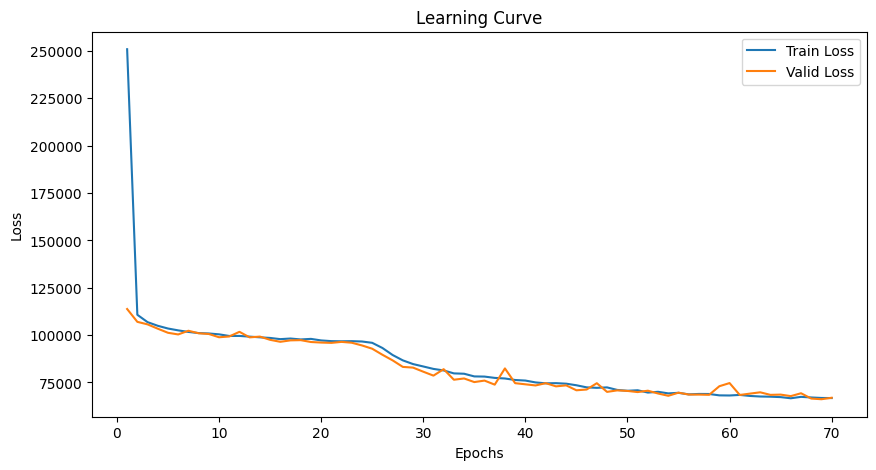

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

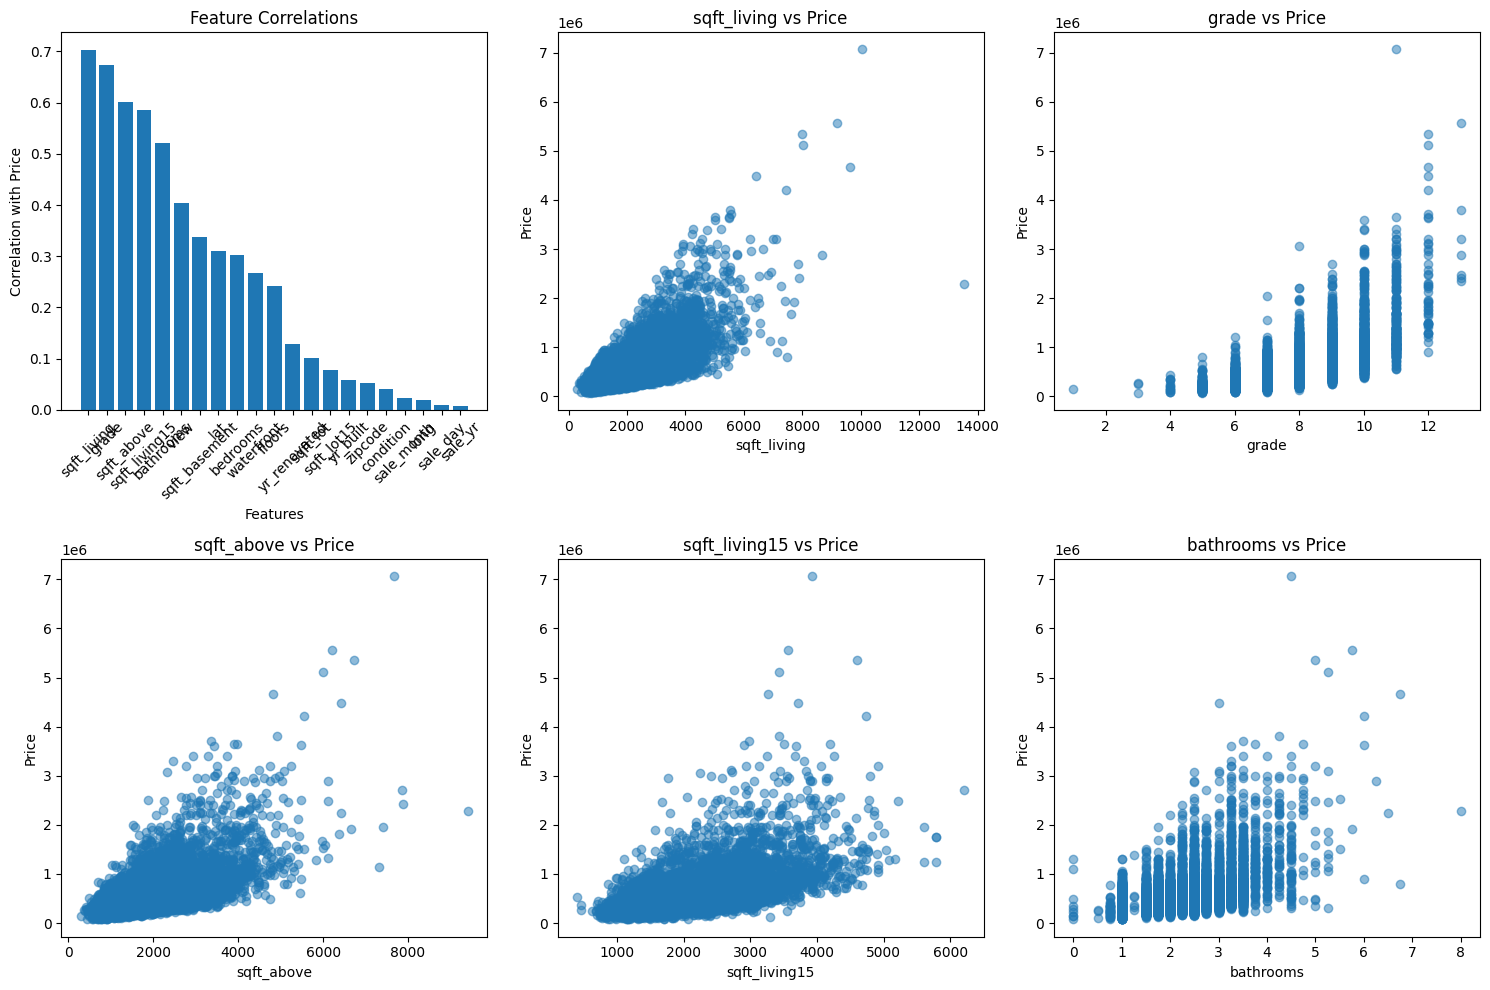

In [ ]:
correlations = train_data.corr()['price'].abs().sort_values(ascending=False)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.bar(correlations.index[1:], correlations[1:])
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.title('Feature Correlations')
plt.xticks(rotation=45)

top_features = correlations[1:6].index
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+2)
    plt.scatter(train_data[feature], train_data['price'], alpha=0.5)
    plt.title(f'{feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


In [ ]:
test_predictions = evaluate(model, test_loader)
submission_df = pd.DataFrame({'id': np.arange(1, len(test_predictions)+1), 'price': test_predictions})
submission_df.to_csv(data_path + 'predictionsnew1.csv', index=False)